# Prédiction trafic en ville

## Table des matières

* [1. Vérification hypothèse de la régression linéaire](#verif_hypo)
* [2. Entrainement des données](#entrainement)
* [3. Evaluation de la régression linéaire](#eval_regression)
* [4. Régression linéaire sur plusieurs modèles](#plus_modeles)
* [5. Prédiction du trafic par arêtes](#prediction_trafic)

On va récupérer, en fonction de différents moments de la journée, le trafic sur chaque arête.  

In [1]:
from pymongo import MongoClient
import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

client = MongoClient('localhost', 27017)
db = client['DataProject']
collection_trafic_stamped = db['vehicules_stamped']

## 1. Vérification hypothèse de la régression linéaire <a class="anchor" id="verif_hypo"></a>

Afin de pouvoir utiliser une régression linéaire il faut démontrer que la relation entre la variable quantitative X (nb de voitures) et Y (temps) est linéaire.

Afin de valider cette hypothèse, commençons par observer graphiquement la relation entre ces deux valeurs.

In [2]:
vehicules_par_minutes = list(collection_trafic_stamped.aggregate([
    {"$project":{"temps":{"heures":{"$hour":"$date_d_insertion"}, 
                          "minutes":{"$minute":"$date_d_insertion"}},
                 "num_arete":1,
                 "nb_vehicules":1}},
    {"$group":{"_id":{"heures":"$temps.heures", "minutes":"$temps.minutes"}, 
               "nb_vehicules":{"$avg":"$nb_vehicules"}}},
    {"$sort":{"_id":1}}
]))
trafics = [trafic["nb_vehicules"] for trafic in vehicules_par_minutes]
print(trafics)

[29.9768, 30.9452, 30.926, 31.7464, 32.8132, 32.8896, 33.8692, 34.4612, 34.446, 35.3536, 35.8556, 36.3852, 37.6336, 37.8288, 38.652, 39.1296, 39.338, 40.724, 40.6288, 41.6044, 41.7192, 42.5276, 42.9464, 44.2436, 44.1584, 44.9968, 44.9072, 46.4676, 46.6284, 47.046, 47.6392, 48.258, 49.4716, 49.5416, 49.7616, 50.9232, 51.3288, 51.7372, 52.8436, 54.038, 54.4756, 54.3596, 55.1576, 55.7652, 55.7648, 57.1224, 57.3416, 58.4328, 58.7364, 59.1516, 60.094, 60.6776, 61.442, 62.5508, 62.3848, 62.5768, 63.5924, 64.3108, 64.6536, 65.8092, 65.7168, 66.8064, 67.412, 67.822, 68.7972, 69.0504, 69.2772, 70.174, 71.2368, 71.78, 72.6092, 72.898, 73.1256, 73.7716, 74.3012, 75.0384, 75.6192, 76.2052, 76.9128, 77.4692, 77.8136, 78.5864, 79.1512, 79.8256, 80.5004, 80.8128, 81.724, 82.6772, 83.3432, 83.126, 84.072, 84.0864, 85.16, 86.124, 85.8152, 87.192, 88.1964, 88.3816, 89.1672, 89.9132, 89.5428, 90.9132, 91.244, 91.4644, 92.546, 93.3088, 93.158, 94.672, 95.4272, 95.3344, 96.3332, 96.4368, 97.5604, 97.7324, 

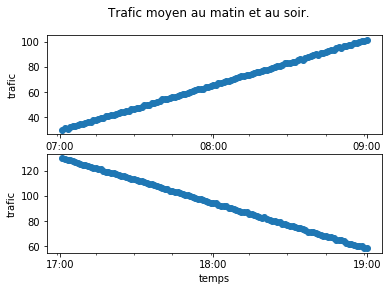

In [3]:
xs = pd.date_range("2020-01-01 07:01", "2020-01-01 09:00", freq = "min").to_pydatetime().tolist()
ys = trafics[:120]
fig, axes = plt.subplots(2)
axes[0].xaxis.set_major_locator(mdates.HourLocator(interval = 1))
axes[0].xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0].set(ylabel="trafic")
axes[0].plot(xs,ys,"o")

xs = pd.date_range("2020-01-01 17:01", "2020-01-01 19:00", freq = "min").to_pydatetime().tolist()
ys = trafics[120:]
axes[1].xaxis.set_major_locator(mdates.HourLocator(interval = 1))
axes[1].xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[1].set(xlabel="temps", ylabel="trafic")
axes[1].plot(xs,ys,"o")
fig.suptitle('Trafic moyen au matin et au soir.')

plt.show()

Nous constatons que le nombre de véhicules augmente ou diminue de façon linéaire en fonction du temps. Cette observation nous permet donc de conforter notre hypothèse sur la linéarité de ces deux valeurs, et donc d'une potentielle utilisation de la régression linéaires.

Afin d'avoir une idée globale sur la linéarité du trafic au niveau des arêtes, nous allons étudier le nombre de véhicules qui passent en moyenne sur les arêtes la plus et la moins congestionnées, aux aurores.

In [4]:
vehicules_par_arete = list(db.vehicules_stamped.aggregate([
    {"$project":{"num_arete":1, "heures":{"$hour":"$date_d_insertion"}, "nb_vehicules":1}},
    {"$match":{"heures":{"$lte":9, "$gte":7}}},
    {"$group":{"_id":"$num_arete", 
               "nb_vehicules":{"$avg":"$nb_vehicules"}}},
    {"$sort":{"nb_vehicules":-1}}
]))
print("Le résultat retourné par la requete :")
print(vehicules_par_arete[0], vehicules_par_arete[-1])

Le résultat retourné par la requete :
{'_id': 111, 'nb_vehicules': 78.13} {'_id': 132, 'nb_vehicules': 52.675}


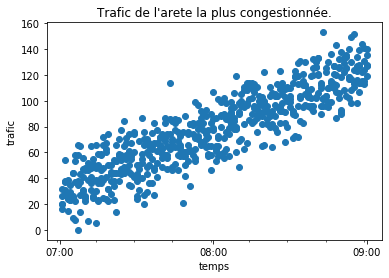

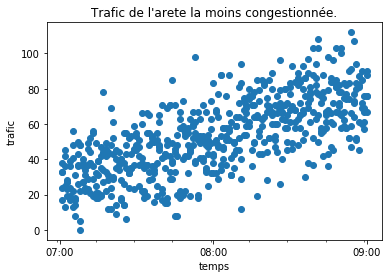

In [5]:
arete_max, arete_min = vehicules_par_arete[0]["_id"], vehicules_par_arete[-1]["_id"]
vehicules_arete_max = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_max}}},
    {"$project":{"temps":{"heures":{"$hour":"$date_d_insertion"}, 
                          "minutes":{"$minute":"$date_d_insertion"}},
                "nb_vehicules":1}},
    {"$match":{"temps.heures":{"$lte":9, "$gte":7}}},
     {"$sort":{"temps":1}}])
vehicules_arete_min = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_min}}},
    {"$project":{"temps":{"heures":{"$hour":"$date_d_insertion"}, 
                          "minutes":{"$minute":"$date_d_insertion"}},
                "nb_vehicules":1}},
    {"$match":{"temps.heures":{"$lte":9, "$gte":7}}},
     {"$sort":{"temps":1}}])

xs = pd.date_range("2020-01-01 07:01", "2020-01-01 09:00", freq = "min").to_pydatetime().tolist()
xs = [e for sub in zip(xs, xs, xs, xs, xs) for e in sub] 

trafics = [trafic["nb_vehicules"] for trafic in vehicules_arete_max]
ys = trafics[:600]
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title="Trafic de l'arete la plus congestionnée.", xlabel="temps", ylabel="trafic")
ax.plot(xs,ys,"o")

trafics = [trafic["nb_vehicules"] for trafic in vehicules_arete_min]
ys = trafics[:600]
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title="Trafic de l'arete la moins congestionnée.", xlabel="temps", ylabel="trafic")
ax.plot(xs,ys,"o")

plt.show()

Une fois de plus la relation semble linéaire entre le temps et le trafic. Avec toutes ces observations il semble pertinent d'effectuer une regression linéaire sur les arête. Cependant, il faut vérifier les conditions relatives à la régression car une simple observation visuelle n'est pas suffisante.

## 2. Entrainement des données <a class="anchor" id="entrainement"></a>

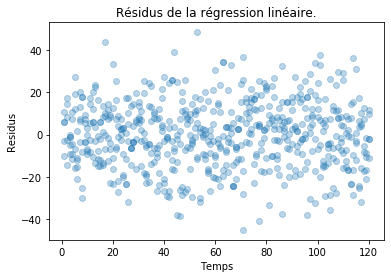

In [6]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import pylab as py

X = [(date.hour-7)*60+date.minute for date in xs]
X = np.append(arr = np.ones((len(X), 1)).astype(int), values = np.array([X]).T, axis = 1)
regressor_OLS = sm.OLS(endog = ys, exog = X).fit()
y_pred = regressor_OLS.params[0]+regressor_OLS.params[1]*X[:,1]

fig, ax = plt.subplots()
ax.scatter(X[:,1], regressor_OLS.resid, alpha=0.3)
ax.set(title="Résidus de la régression linéaire.", xlabel="Temps", ylabel="Residus")
plt.show()

Ce résultat est plutôt rassurant, car les résidus semblent se comporter de manière assez cohérence. Nous allons à présent appliquer un test statistique sur la variance, afin de démontrer son homoscésdasticité et de valider une propriété fondamentale du modèle de la régression linéaire.

In [7]:
print("Test d'homogeneite (H0 : La variance des residus est homogène)")
print('p valeur de Goldfeld–Quandt test est: ', 
      sms.het_goldfeldquandt(ys, regressor_OLS.model.exog)[1])
print('p valeur of Breusch–Pagan test est: ', sms.het_breuschpagan(regressor_OLS.resid, 
                                                                 regressor_OLS.model.exog)[1])
print('p valeur de White test est: ', sms.het_white(regressor_OLS.resid**2, 
                                                   regressor_OLS.model.exog)[1])

Test d'homogeneite (H0 : La variance des residus est homogène)
p valeur de Goldfeld–Quandt test est:  0.10985517028492815
p valeur of Breusch–Pagan test est:  0.06741969743670223
p valeur de White test est:  0.06722593500122953


L'hypothèse nulle formulée était que la variance est constante. Le risque 𝛼 que nous avons calculé dans ce test à l'aide des trois tests cités ci-dessus, ne nous ont pas permis de rejeter notre hypothèse, car les risques calculés ont une probabilité supérieur à 𝛼=0.05.
Nous pouvons maintenant utiliser une loi normale afin d'avoir une représentation graphique de la normalité des résidus.

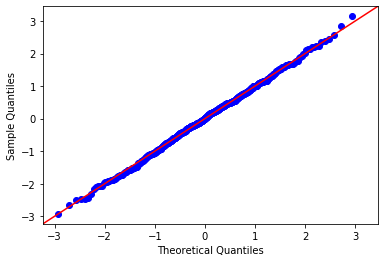

In [8]:
from scipy import stats
import pylab as py

sm.qqplot(regressor_OLS.resid_pearson, line ='45') 
py.show()

Au vu de ce graphique, les résidus semblent suivre une loi normale. Afin de valider cette hypothèse nous allons effectuer un test de normalité sur ces données.

In [9]:
print("Test de normalite (H0 : les donnes suivent une loi Normale)")
print('p valeur de Jarque-Bera test est: ', stats.jarque_bera(regressor_OLS.resid)[1])
print('p value de Shapiro-Wilk test est: ', stats.shapiro(regressor_OLS.resid)[1])

Test de normalite (H0 : les donnes suivent une loi Normale)
p valeur de Jarque-Bera test est:  0.8403005397607842
p value de Shapiro-Wilk test est:  0.933542013168335


Nous ne pouvons toujours pas rejeter l'hypothèse formulée, car nos résultats sont toujours supérieurs à notre seuil de signification.

## 3. Evaluation de la régression linéaire <a class="anchor" id="eval_regression"></a>

Les hypothèses de la régression linéaire ont été validées, nous pouvons à présent évaluer les performances de notre modèle.

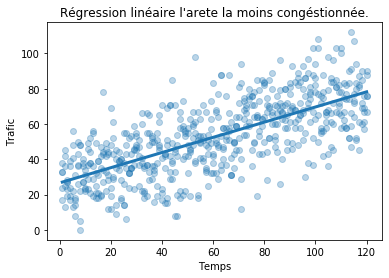

In [10]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

fig, ax = plt.subplots()
ax.scatter(X[:,1], ys, alpha=0.3)
ax.set(title="Régression linéaire l'arete la moins congéstionnée.", xlabel="Temps", ylabel="Trafic")
ax.plot(X[:,1], y_pred, linewidth=3)
plt.show()

In [11]:
print("Evaluation de la regression lineaire en utilisant la classe statsmodels :")
print("Les parametres de la regression sont ", regressor_OLS.params)
print("La valeur du R2 est ", regressor_OLS.rsquared)
print("Les test de Fischer sur la qualite globale de la regression ")
print("f_value ", regressor_OLS.fvalue, " f_pvalue",regressor_OLS.f_pvalue)
print("Le resultat des t-tests ")
print("p valeurs ", regressor_OLS.pvalues, " t valeurs ", regressor_OLS.tvalues)

Evaluation de la regression lineaire en utilisant la classe statsmodels :
Les parametres de la regression sont  [26.66722689  0.42988055]
La valeur du R2 est  0.48314287642084675
Les test de Fischer sur la qualite globale de la regression 
f_value  558.9928568633151  f_pvalue 9.297808129102892e-88
Le resultat des t-tests 
p valeurs  [5.79931988e-74 9.29780813e-88]  t valeurs  [21.03815308 23.64302977]


Nous observons que les paramètres de la droite (t valeurs) sont significativement différent de zéro et le coefficient de détermination R2 est de 0.5, on peut en conclure que le modèle capture globalement les variations dans les données.

## 4. Régression linéaire sur plusieurs modèles <a class="anchor" id="plus_modeles"></a>

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

nb_aretes = 500
nb_regression_models = 500
nb_aretes_per_model = nb_aretes/ nb_regression_models
regression_models = [None]*nb_regression_models
for i in range(nb_regression_models):
    #print(i)
    num_premiere_arete, num_derniere_arete = i*nb_aretes_per_model, (i+1)*nb_aretes_per_model-1 
    X = list(db.vehicules_stamped.aggregate([
        {"$match":{"num_arete":{"$gte":num_premiere_arete, "$lte":num_derniere_arete}}},
        {"$project":{"temps":{"heures":{"$hour":"$date_d_insertion"}, 
                              "minutes":{"$minute":"$date_d_insertion"}},
                    "nb_vehicules":1,"num_arete":1}},
        {"$match":{"temps.heures":{"$lte":9, "$gte":7}}}]))
    X = [[trafic["num_arete"],
                60*(trafic["temps"]["heures"]-7)+trafic["temps"]["minutes"], 
                trafic["nb_vehicules"]] for trafic in X]

    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], 
                           remainder="passthrough")
    X = ct.fit_transform(X)
    if isinstance(X, np.ndarray) is False:
        X = X.toarray()
    else :
        X = np.array(X, dtype = int)
    
    ys = X[:,-1]
    X = X[:, 1:-1]
    X = np.append(arr = np.ones((X.shape[0], 1)), values = X, axis = 1)

    regression_models[i] = sm.OLS(endog = ys, exog = X).fit()

seuil = 0.05
nb_regressors = int(nb_aretes_per_model+1)
cpts_ts = [[0]*nb_regressors for i in range(nb_regression_models)] 
cpts_f = [0]*nb_regression_models
for i in range(nb_regression_models):
    pvalues_t_test = regression_models[i].pvalues
    pvalue_f_test =  regression_models[i].f_pvalue
    for j in range(len(pvalues_t_test)):
        if pvalues_t_test[j] >= seuil:
            cpts_ts[i][j] += 1
            #print("p-valeur associee a la variable "+str(j)+" est "+str(pvalues_t_test [j]))
    if pvalue_f_test >= seuil:
        cpts_f[i] += 1
        #print("p-valeur du f-test est "+str(pvalue_f_test))
print("Proportion associee aux t-tests ", 
      [sum(
              [cpts_ts[i][j] for i in range(nb_regression_models)]
          )/nb_regression_models for j in range(nb_regressors)])
print("Proportion associee aux f-tests ", sum(cpts_f)/nb_regression_models)
print("Tous les tests sont completees.")

Proportion associee aux t-tests  [0.0, 0.0]
Proportion associee aux f-tests  0.0
Tous les tests sont completees.


Suite à cette régression linéaire multiple, nous constatons que les paramètres *p* de la droite sont significativement différent de zéro. Or, si la valeur de p est inférieure ou égale au seuil de signification (0.05), nous pouvons rejeter l'hypothèse nulle, ce qui revient à dire que le modèle linéaire a du sens pour la variable associée à ce seuil.

## 5. Prédiction du trafic par arêtes <a class="anchor" id="prediction_trafic"></a>

Maintenant que notre modèle statistique valide la régression linéaire, nous pouvons utiliser nos données afin de prédire le trafic pour chaque arête.
Nous allons donc créer une collection dans notre base de données, qui pour chaque arête nous affichera le trafic moyen pour deux périodes de la journée. 

In [42]:
trafic_par_arete_matin = list(db.vehicules_stamped.aggregate([
    {"$project":{"num_arete":1, "heures":{"$hour":"$date_d_insertion"}, "nb_vehicules":1}},
    {"$match":{"heures":{"$lte":9, "$gte":7}}},
    {"$group":{"_id":"$num_arete",
               "nb_vehicules":{"$avg":"$nb_vehicules"}}},
    {"$sort":{"_id":1}}
]))
trafic_par_arete_soir = list(db.vehicules_stamped.aggregate([
    {"$project":{"num_arete":1, "heures":{"$hour":"$date_d_insertion"}, "nb_vehicules":1}},
    {"$match":{"heures":{"$lte":19, "$gte":17}}},
    {"$group":{"_id":"$num_arete",
               "nb_vehicules":{"$avg":"$nb_vehicules"}}},
    {"$sort":{"_id":1}}
]))

trafic_collection = db["trafic_collection"]
trafic_collection.drop()
dict_trafic = {}

for i in range(len(trafic_par_arete_matin)):
    dict_trafic = {
        'num_arete' : i,
        'trafic_matin':trafic_par_arete_matin[i]["nb_vehicules"],
        'trafic_soir':trafic_par_arete_soir[i]["nb_vehicules"]
    }
    
    trafic_collection.insert_one(dict_trafic)
    dict_trafic = {}